Initial Setup and Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import os
import re
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

os.environ['NLTK_DATA'] = '/usr/share/nltk_data/'
!mkdir -p /usr/share/nltk_data
nltk.download('punkt_tab', download_dir='/usr/share/nltk_data')
nltk.download('all', download_dir='/usr/share/nltk_data')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /usr/share/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /usr/share/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_da

True

In [ ]:
import pandas as pd
import numpy as np
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# First, define the text preprocessing function
def preprocess_text(text):
    """
    Clean and preprocess text by:
    1. Lowercasing
    2. Removing special characters
    3. Removing stopwords
    4. Removing short words
    """
    # Ensure text is string
    text = str(text)

    # Lowercase
    text = text.lower()

    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize and remove stopwords
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    words = [w for w in words if w not in stop_words and len(w) > 2]

    return ' '.join(words)

# Now load and clean the dataset
file_path = '/content/drive/MyDrive/UPHILL.csv'
df = pd.read_csv(file_path)

print(f"\n=== Original Dataset Summary ===\n"
      f"Rows: {df.shape[0]:,}\n"
      f"Columns: {df.shape[1]}\n")
print("NaN counts per column:")
print(df.isna().sum())

# Enhanced cleaning function
def clean_uphill_data(df):
    """Thoroughly clean UPHILL dataset while preserving structure"""
    original_shape = df.shape

    # 1. Critical columns - remove rows if these are NaN
    critical_cols = ['claim', 'claim_veracity']
    df = df.dropna(subset=critical_cols)

    # 2. Text columns - fill with empty string
    text_cols = ['veracity_explanation', 'subjects', 'main_text', 'sources',
                 'model_response', 'prediction_reasoning']
    df[text_cols] = df[text_cols].fillna('')

    # 3. Categorical columns - fill with 'unknown'
    cat_cols = ['source_db', 'fact_checkers', 'conversational_model']
    df[cat_cols] = df[cat_cols].fillna('unknown')

    # 4. Numeric columns - fill with 0 (for response_num) or median
    df['response_num'] = df['response_num'].fillna(0)

    # 5. Date columns - convert to datetime and fill with min date
    df['date_published'] = pd.to_datetime(df['date_published'], errors='coerce')
    min_date = df['date_published'].min()
    df['date_published'] = df['date_published'].fillna(min_date)

    # 6. Clean claim text (if column doesn't exist)
    if 'clean_claim' not in df.columns:
        df['clean_claim'] = df['claim'].apply(preprocess_text)  # Now properly defined

    # 7. Drop remaining NaN rows if any exist
    df = df.dropna()

    print(f"\nRemoved {original_shape[0] - df.shape[0]} rows ({100*(original_shape[0]-df.shape[0])/original_shape[0]:.1f}%) due to NaN values")
    return df

# Clean the data
df = clean_uphill_data(df)

# Final verification
print(f"\n=== Cleaned Dataset Summary ===\n"
      f"Rows: {df.shape[0]:,}\n"
      f"Columns: {df.shape[1]}\n")
print("NaN counts after cleaning:")
print(df.isna().sum())

print("\n=== Sample Rows After Cleaning ===")
print(df.head(3).to_string(index=False, max_colwidth=30))
print("\n=== Last 3 Rows After Cleaning ===")
print(df.tail(3).to_string(index=False, max_colwidth=30))


=== Original Dataset Summary ===
Rows: 115,870
Columns: 18

NaN counts per column:
claim_id                         0
claim                            0
claim_veracity                   0
veracity_explanation         18610
subjects                      9130
date_published               25030
source_db                        0
fact_checkers                62770
main_text                    62770
sources                      62770
presupposition_level             0
query_with_presupposition        0
conversational_model             0
response_num                     0
query_response_id                0
model_response                 561
entailment_prediction            1
prediction_reasoning             1
dtype: int64

Removed 1 rows (0.0%) due to NaN values

=== Cleaned Dataset Summary ===
Rows: 115,869
Columns: 19

NaN counts after cleaning:
claim_id                     0
claim                        0
claim_veracity               0
veracity_explanation         0
subjects             


=== Claim Veracity Distribution ===
True claims:      45,959
False claims:     51,240
Mixture claims:   9,540
Fabricated claims: 9,130

=== Percentage Breakdown ===
True claims:      39.7%
False claims:     44.2%
Mixture claims:   8.2%
Fabricated claims: 7.9%


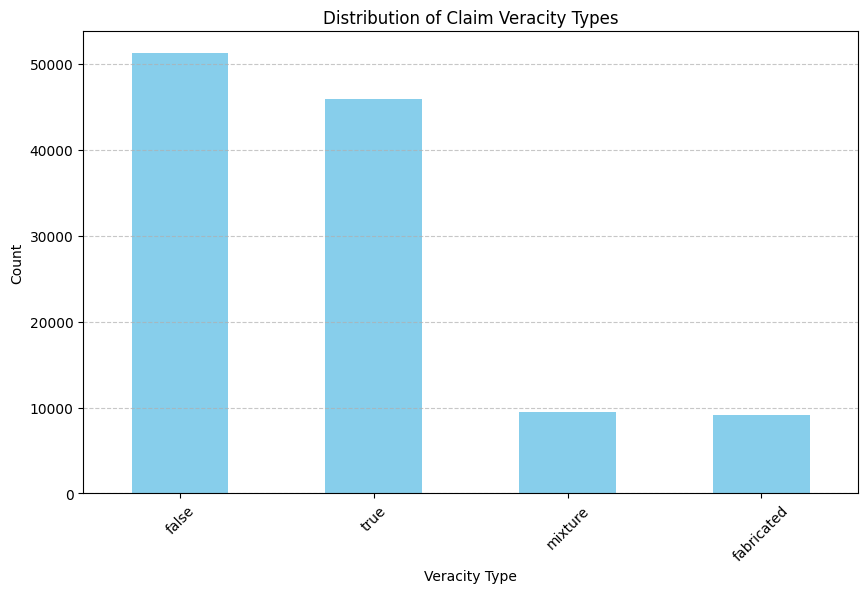

In [ ]:
# Count the occurrences of each claim veracity type
veracity_counts = df['claim_veracity'].value_counts()

# Print the counts in a clear format
print("\n=== Claim Veracity Distribution ===")
print("="*40)
print(f"True claims:      {veracity_counts.get('true', 0):,}")
print(f"False claims:     {veracity_counts.get('false', 0):,}")
print(f"Mixture claims:   {veracity_counts.get('mixture', 0):,}")
print(f"Fabricated claims: {veracity_counts.get('fabricated', 0):,}")
print("="*40)

# Optional: Calculate and print percentages
total = len(df)
print("\n=== Percentage Breakdown ===")
print("="*40)
print(f"True claims:      {veracity_counts.get('true', 0)/total:.1%}")
print(f"False claims:     {veracity_counts.get('false', 0)/total:.1%}")
print(f"Mixture claims:   {veracity_counts.get('mixture', 0)/total:.1%}")
print(f"Fabricated claims: {veracity_counts.get('fabricated', 0)/total:.1%}")
print("="*40)

# Optional: Visual representation
import matplotlib.pyplot as plt

veracity_counts.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Distribution of Claim Veracity Types')
plt.xlabel('Veracity Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:

# Define the column explanations
column_explanations = {
    'claim_id': 'Unique identifier for each health claim',
    'claim': 'Text of the health claim being fact-checked',
    'claim_veracity': 'Ground truth label (true/false/mixture/fabricated)',
    'veracity_explanation': 'Detailed explanation from fact-checkers supporting the veracity judgment',
    'subjects': 'Topics/categories the claim belongs to (e.g., medical, COVID-19)',
    'date_published': 'When the claim was originally published',
    'source_db': 'Source database (pubhealth/monant/fabricated)',
    'fact_checkers': 'Names of organizations/individuals who fact-checked the claim',
    'main_text': 'Detailed fact-checking article text',
    'sources': 'References/citations used in fact-checking',
    'presupposition_level': 'How strongly the claim assumes truth (Neutral/Mild/Unequivocal)',
    'entailment_prediction': 'Whether evidence supports the claim (agree/disagree/neutral)'
}

# Print the formatted output
print("\n\033[1mKEY COLUMNS IN UPHILL DATASET\033[0m")
print("-" * 50)
for col, explanation in column_explanations.items():
    print(f"\033[1m{col:<25}\033[0m {explanation}")
print("-" * 50)
print(f"\nDataset contains {len(df.columns)} total columns ({len(column_explanations)} key columns shown)")


KEY COLUMNS IN UPHILL DATASET
--------------------------------------------------
claim_id                  Unique identifier for each health claim
claim                     Text of the health claim being fact-checked
claim_veracity            Ground truth label (true/false/mixture/fabricated)
veracity_explanation      Detailed explanation from fact-checkers supporting the veracity judgment
subjects                  Topics/categories the claim belongs to (e.g., medical, COVID-19)
date_published            When the claim was originally published
source_db                 Source database (pubhealth/monant/fabricated)
fact_checkers             Names of organizations/individuals who fact-checked the claim
main_text                 Detailed fact-checking article text
sources                   References/citations used in fact-checking
presupposition_level      How strongly the claim assumes truth (Neutral/Mild/Unequivocal)
entailment_prediction     Whether evidence supports the claim (agree

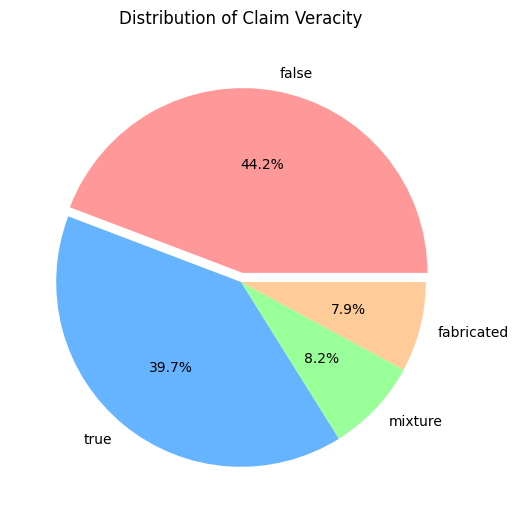

In [ ]:
#Shows class imbalance at a glance
# Prepare data
veracity_counts = df['claim_veracity'].value_counts()

# Plot
plt.figure(figsize=(8,6))
veracity_counts.plot(kind='pie', autopct='%1.1f%%',
                    colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'],
                    explode=(0.05, 0, 0, 0))
plt.title('Distribution of Claim Veracity', pad=20)
plt.ylabel('')
plt.show()

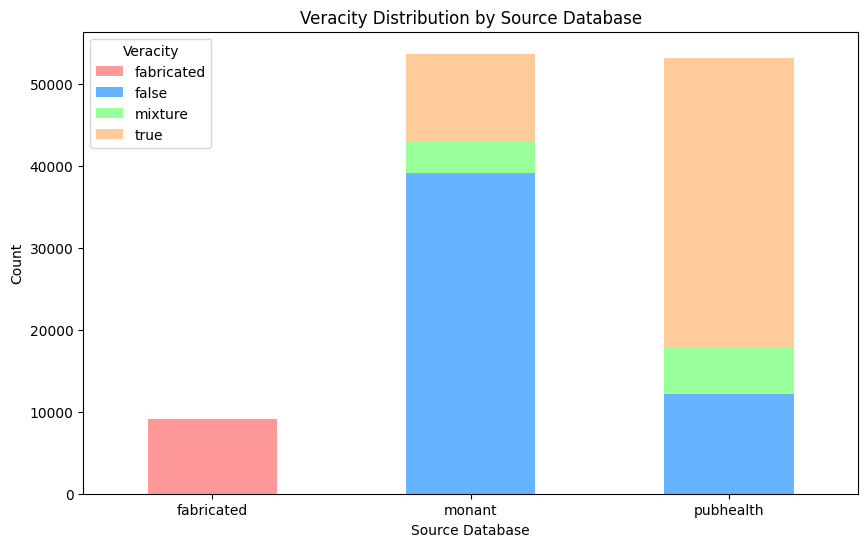

In [ ]:
#source_db vs claim_veracity
#Reveals if certain sources have more false claims.
# Cross-tabulation
ct = pd.crosstab(df['source_db'], df['claim_veracity'])

# Plot
ct.plot(kind='bar', stacked=True, figsize=(10,6),
       color=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
plt.title('Veracity Distribution by Source Database')
plt.xlabel('Source Database')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Veracity')
plt.show()

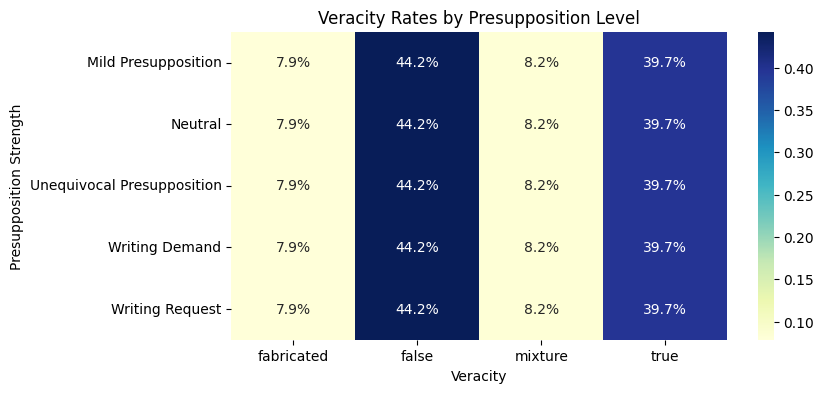

In [ ]:
# Prepare data
# Shows how claim phrasing affects truthfulness.
presup_heatmap = pd.crosstab(df['presupposition_level'],
                            df['claim_veracity'],
                            normalize='index')

# Plot
plt.figure(figsize=(8,4))
sns.heatmap(presup_heatmap, annot=True, fmt='.1%', cmap='YlGnBu')
plt.title('Veracity Rates by Presupposition Level')
plt.xlabel('Veracity')
plt.ylabel('Presupposition Strength')
plt.show()

Secure preprocessing

In [ ]:
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = nltk.word_tokenize(text)
    words = [w for w in words if w not in stop_words and len(w) > 2]
    return ' '.join(words)

df['clean_claim'] = df['claim'].apply(preprocess_text)
df['target'] = df['claim_veracity'].apply(lambda x: 1 if x == 'true' else 0)

Train Test Split Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_claim'],
    df['target'],
    test_size=0.3,
    random_state=42,
    stratify=df['target']
)

Feature Engineering (Tf-IDF Vectorization)

In [ ]:
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

Model Training


Random Forest Accuracy: 60.44%

Classification Report:
              precision    recall  f1-score   support

           0       0.60      1.00      0.75     20973
           1       1.00      0.00      0.01     13788

    accuracy                           0.60     34761
   macro avg       0.80      0.50      0.38     34761
weighted avg       0.76      0.60      0.46     34761



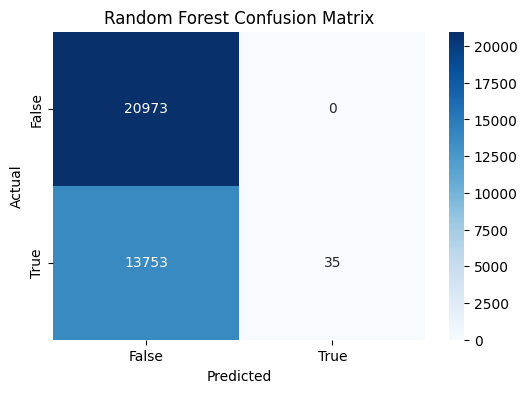

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:33:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Accuracy: 98.05%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     20973
           1       0.96      0.99      0.98     13788

    accuracy                           0.98     34761
   macro avg       0.98      0.98      0.98     34761
weighted avg       0.98      0.98      0.98     34761



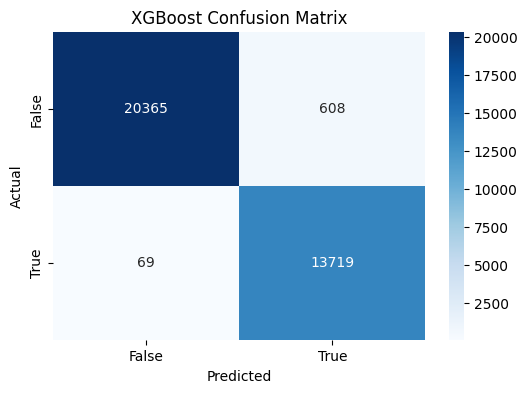


K-Nearest Neighbors Accuracy: 99.94%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20973
           1       1.00      1.00      1.00     13788

    accuracy                           1.00     34761
   macro avg       1.00      1.00      1.00     34761
weighted avg       1.00      1.00      1.00     34761



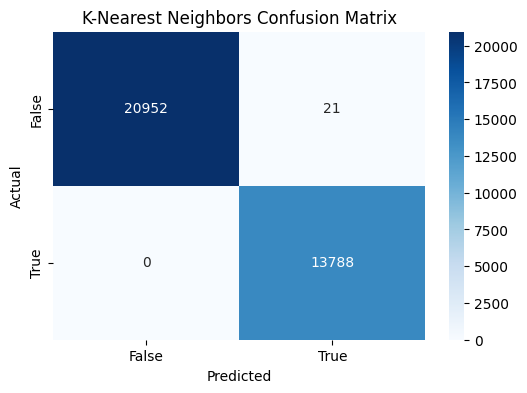


Gradient Boosting Accuracy: 78.00%

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.98      0.84     20973
           1       0.95      0.47      0.63     13788

    accuracy                           0.78     34761
   macro avg       0.84      0.73      0.74     34761
weighted avg       0.82      0.78      0.76     34761



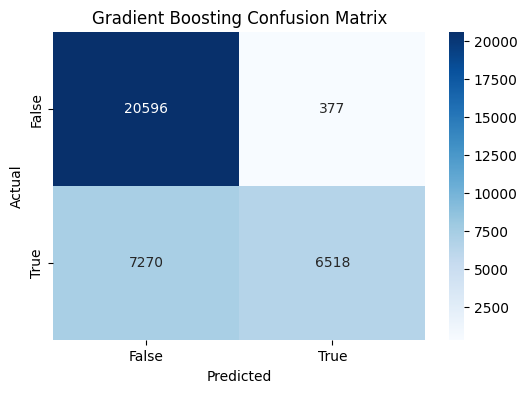

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def train_and_evaluate(model, model_name):
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n{model_name} Accuracy: {accuracy:.2%}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['False', 'True'],
                yticklabels=['False', 'True'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    return accuracy

# Initialize new models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
}

# Evaluate all models
results = {}
for name, model in models.items():
    results[name] = train_and_evaluate(model, name)


Sample Predictions

In [ ]:
def predict_claim(text, model):
    cleaned = preprocess_text(text)
    vectorized = tfidf.transform([cleaned])
    pred = model.predict(vectorized)[0]
    return "True" if pred == 1 else "False"

sample_claims = [
    "Vitamin D prevents all diseases",
    "Exercise improves cardiovascular health",
    "5G towers spread viruses"
]

print("\nSample Predictions:")
for claim in sample_claims:
    print(f"\nClaim: {claim}")
    for name, model in models.items():
        print(f"{name}: {predict_claim(claim, model)}")


Sample Predictions:

Claim: Vitamin D prevents all diseases
Random Forest: False
XGBoost: True
K-Nearest Neighbors: True
Gradient Boosting: False

Claim: Exercise improves cardiovascular health
Random Forest: False
XGBoost: True
K-Nearest Neighbors: True
Gradient Boosting: True

Claim: 5G towers spread viruses
Random Forest: False
XGBoost: False
K-Nearest Neighbors: False
Gradient Boosting: False


ROC Curve Visualization

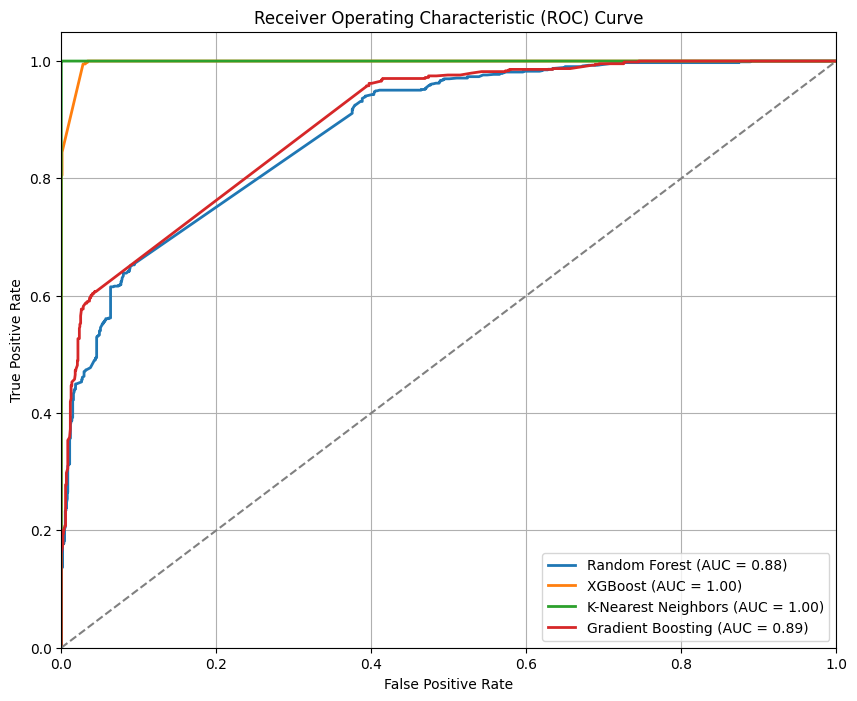

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns

plt.figure(figsize=(10, 8))

for name, model in models.items():
    # Get predicted probabilities for the positive class
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_tfidf)[:, 1]
    elif hasattr(model, "decision_function"):  # For LinearSVC
        y_proba = model.decision_function(X_test_tfidf)
        y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())  # Scale to [0,1]
    else:
        continue

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    # Plot
    plt.plot(fpr, tpr, lw=2,
             label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
# Table comparing all models
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [f"{acc:.2%}" for acc in results.values()],
    'Precision (True)': [classification_report(y_test, m.predict(X_test_tfidf), output_dict=True)['1']['precision']
                         for m in models.values()],
    'Recall (True)': [classification_report(y_test, m.predict(X_test_tfidf), output_dict=True)['1']['recall']
                      for m in models.values()]
}).set_index('Model')

print(results_df)

                    Accuracy  Precision (True)  Recall (True)
Model                                                        
Random Forest         60.44%          1.000000       0.002538
XGBoost               98.05%          0.957563       0.994996
K-Nearest Neighbors   99.94%          0.998479       1.000000
Gradient Boosting     78.00%          0.945323       0.472730


Fixing all Baseline Models


Improved Random Forest Accuracy: 81.08%

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.70      0.82     20973
           1       0.68      0.98      0.80     13788

    accuracy                           0.81     34761
   macro avg       0.83      0.84      0.81     34761
weighted avg       0.86      0.81      0.81     34761



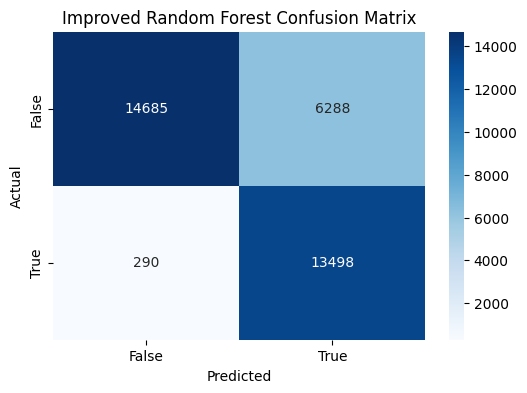

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:37:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Accuracy: 94.32%

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95     20973
           1       0.89      0.98      0.93     13788

    accuracy                           0.94     34761
   macro avg       0.94      0.95      0.94     34761
weighted avg       0.95      0.94      0.94     34761



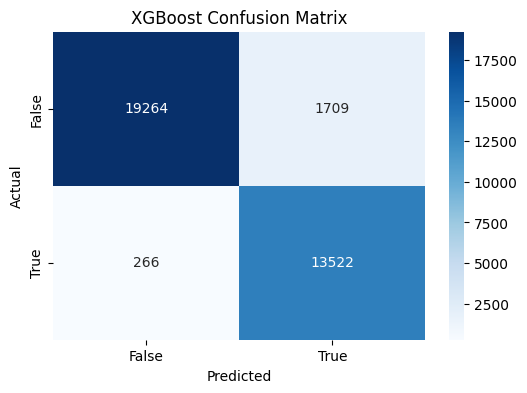


K-Nearest Neighbors Accuracy: 99.94%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20973
           1       1.00      1.00      1.00     13788

    accuracy                           1.00     34761
   macro avg       1.00      1.00      1.00     34761
weighted avg       1.00      1.00      1.00     34761



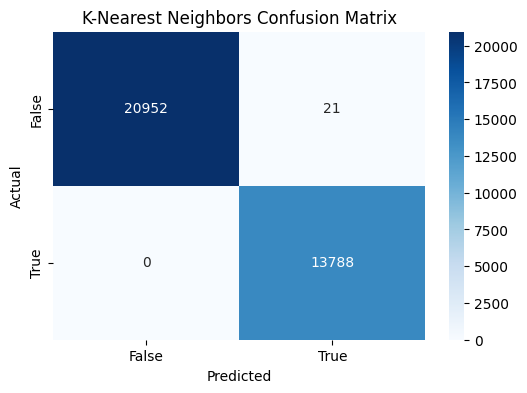


Improved Gradient Boosting Accuracy: 89.82%

Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92     20973
           1       0.99      0.75      0.85     13788

    accuracy                           0.90     34761
   macro avg       0.93      0.87      0.89     34761
weighted avg       0.91      0.90      0.89     34761



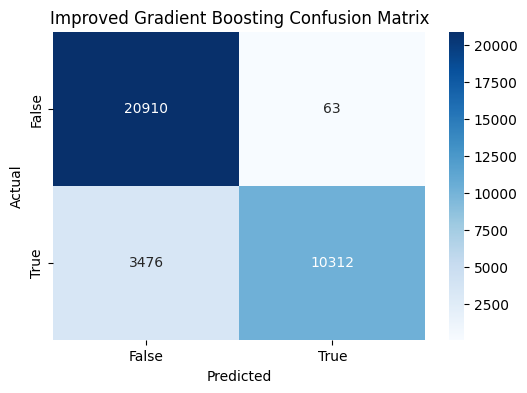

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def train_and_evaluate(model, model_name):
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n{model_name} Accuracy: {accuracy:.2%}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['False', 'True'],
                yticklabels=['False', 'True'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    return accuracy

# Improved models
models = {
    "Improved Random Forest": RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=10,
        class_weight='balanced',
        random_state=42
    ),
    "XGBoost": XGBClassifier(
        use_label_encoder=False,
        eval_metric='mlogloss',
        learning_rate=0.1,
        n_estimators=150,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ),
    "K-Nearest Neighbors": KNeighborsClassifier(
        n_neighbors=5
    ),
    "Improved Gradient Boosting": GradientBoostingClassifier(
        n_estimators=150,
        learning_rate=0.1,
        max_depth=5,
        min_samples_split=10,
        subsample=0.8,
        random_state=42
    )
}

# Evaluate models
results = {}
for name, model in models.items():
    results[name] = train_and_evaluate(model, name)


Advanced Feature Engineering

In [ ]:
# Install required packages
!pip install vaderSentiment textstat

import numpy as np
from scipy.sparse import hstack
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import textstat

# 1. Enhanced TF-IDF with N-grams
tfidf_enhanced = TfidfVectorizer(
    ngram_range=(1, 3),      # Capture phrases
    max_features=5000,       # Control memory usage
    stop_words='english',    # Remove noise
    sublinear_tf=True        # Logarithmic scaling
)
X_tfidf = tfidf_enhanced.fit_transform(df['clean_claim'])

# 2. Sentiment Analysis
analyzer = SentimentIntensityAnalyzer()
df['sentiment'] = df['claim'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# 3. Readability Scores
df['readability'] = df['claim'].apply(textstat.flesch_reading_ease)

# 4. Claim Length Features
df['char_count'] = df['claim'].apply(len)
df['word_count'] = df['claim'].apply(lambda x: len(x.split()))

# 5. Metadata Features (if available)
if 'presupposition_level' in df.columns:
    df['presupposition_num'] = df['presupposition_level'].map({'Neutral':0, 'Mild':1, 'Unequivocal':2})

# Combine all features
numeric_features = ['sentiment', 'readability', 'char_count', 'word_count']
if 'presupposition_num' in df.columns:
    numeric_features.append('presupposition_num')

X_numeric = df[numeric_features].values
X_combined = hstack([X_tfidf, X_numeric])

# Update train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_combined,
    df['target'],
    test_size=0.3,
    random_state=42,
    stratify=df['target']
)

Base-line models Rerun

In [ ]:
import numpy as np
from scipy.sparse import issparse, csr_matrix
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# 1. SAFE FEATURE IMPUTATION
def safe_impute(X_train, X_test):
    """Handle NaN values while preserving sparse matrix structure"""
    if issparse(X_train):
        # Convert to dense for imputation if sparse matrix contains NaNs
        if np.isnan(X_train.data).any():
            X_train_dense = X_train.toarray()
            X_test_dense = X_test.toarray()

            imputer = SimpleImputer(strategy='mean')
            X_train_imputed = imputer.fit_transform(X_train_dense)
            X_test_imputed = imputer.transform(X_test_dense)

            return csr_matrix(X_train_imputed), csr_matrix(X_test_imputed)
        return X_train, X_test
    else:
        # Dense matrix handling
        imputer = SimpleImputer(strategy='mean')
        return imputer.fit_transform(X_train), imputer.transform(X_test)

X_train_fixed, X_test_fixed = safe_impute(X_train, X_test)

# 2. MODEL EVALUATION PIPELINE
def evaluate_model(model, model_name, X_train, X_test, y_train, y_test):
    try:
        print(f"\n\033[1m{model_name}\033[0m")
        print("="*60)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        print(f"Accuracy: \033[1m{accuracy_score(y_test, y_pred):.2%}\033[0m")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        # Feature importance (tree-based models only)
        if hasattr(model, 'feature_importances_'):
            top_n = 10
            importances = model.feature_importances_
            try:
                feature_names = list(tfidf_enhanced.get_feature_names_out()) + numeric_features
            except:
                feature_names = [f"feat_{i}" for i in range(importances.shape[0])]

            print(f"\nTop {top_n} Features:")
            for idx in np.argsort(importances)[-top_n:][::-1]:
                print(f"{feature_names[idx]}: {importances[idx]:.4f}")

    except Exception as e:
        print(f"\n\033[31mError in {model_name}: {str(e)}\033[0m")

# 3. RUN SELECTED MODELS
models = [
    ("Random Forest",
     RandomForestClassifier(
         n_estimators=300,
         max_depth=20,
         class_weight='balanced_subsample',
         max_features='log2',
         random_state=42)),

    ("Gradient Boosting",
     GradientBoostingClassifier(
         n_estimators=150,
         learning_rate=0.1,
         max_depth=5,
         min_samples_split=10,
         subsample=0.8,
         random_state=42)),

    ("XGBoost",
     XGBClassifier(
         use_label_encoder=False,
         eval_metric='mlogloss',
         learning_rate=0.1,
         n_estimators=150,
         max_depth=6,
         subsample=0.8,
         colsample_bytree=0.8,
         random_state=42)),

    ("K-Nearest Neighbors",
     KNeighborsClassifier(n_neighbors=5))
]

for name, model in models:
    evaluate_model(model, name, X_train_fixed, X_test_fixed, y_train, y_test)

# 4. DATA QUALITY CHECK (Optional)
print("\n\033[1mData Quality Report\033[0m")
print("="*60)
print(f"NaN values in X_train: {np.isnan(X_train_fixed.toarray()).sum()}")
print(f"NaN values in X_test: {np.isnan(X_test_fixed.toarray()).sum()}")
print(f"Class distribution (Train): {np.bincount(y_train)}")
print(f"Class distribution (Test): {np.bincount(y_test)}")



Random Forest
Accuracy: 88.14%

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.83      0.89     20973
           1       0.79      0.96      0.87     13788

    accuracy                           0.88     34761
   macro avg       0.88      0.89      0.88     34761
weighted avg       0.90      0.88      0.88     34761


Top 10 Features:
char_count: 0.0400
word_count: 0.0393
treat: 0.0255
covid: 0.0247
treat cancer: 0.0217
readability: 0.0152
cancer: 0.0141
sentiment: 0.0116
people: 0.0110
vaccines: 0.0084

Gradient Boosting
Accuracy: 91.08%

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.93     20973
           1       0.87      0.91      0.89     13788

    accuracy                           0.91     34761
   macro avg       0.91      0.91      0.91     34761
weighted avg       0.91      0.91      0.91     34761


Top 10 Features:
char_count: 0.3329
tre

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:40:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 93.69%

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95     20973
           1       0.90      0.94      0.92     13788

    accuracy                           0.94     34761
   macro avg       0.93      0.94      0.93     34761
weighted avg       0.94      0.94      0.94     34761


Top 10 Features:
treat: 0.0141
word_count: 0.0138
char_count: 0.0104
treat cancer: 0.0086
beneficial managing: 0.0081
mental health: 0.0078
test: 0.0078
shortage: 0.0068
vaccines: 0.0067
stay: 0.0064

K-Nearest Neighbors
Accuracy: 99.96%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20973
           1       1.00      1.00      1.00     13788

    accuracy                           1.00     34761
   macro avg       1.00      1.00      1.00     34761
weighted avg       1.00      1.00      1.00     34761


Data Quality Report
NaN values in X_train

Tabulated Report of Base-line Models

In [ ]:
from tabulate import tabulate
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import pandas as pd

# Initialize results storage
results = []

# Define improved models
models = [
    ("Random Forest",
     RandomForestClassifier(
         n_estimators=300, max_depth=20,
         class_weight='balanced_subsample',
         max_features='log2', random_state=42)),

    ("Gradient Boosting",
     GradientBoostingClassifier(
         n_estimators=150, learning_rate=0.1,
         max_depth=5, min_samples_split=10,
         subsample=0.8, random_state=42)),

    ("XGBoost",
     XGBClassifier(
         use_label_encoder=False, eval_metric='mlogloss',
         learning_rate=0.1, n_estimators=150,
         max_depth=6, subsample=0.8,
         colsample_bytree=0.8, random_state=42)),

    ("K-Nearest Neighbors",
     KNeighborsClassifier(n_neighbors=5))
]

# Evaluate each model
for name, model in models:
    model.fit(X_train_fixed, y_train)
    y_pred = model.predict(X_test_fixed)

    results.append({
        'Model': name,
        'Accuracy': f"{accuracy_score(y_test, y_pred):.2%}",
        'Precision (Weighted)': f"{precision_score(y_test, y_pred, average='weighted'):.2%}",
        'Recall (Weighted)': f"{recall_score(y_test, y_pred, average='weighted'):.2%}",
        'F1-Score (Weighted)': f"{f1_score(y_test, y_pred, average='weighted'):.2%}",
        'Parameters': str(model.get_params())[:70] + "..."
    })

# Convert to DataFrame and display
results_df = pd.DataFrame(results)
print("\n\033[1mImproved Models Performance Comparison\033[0m")
print(tabulate(results_df, headers='keys', tablefmt='pretty', showindex=False))

# Optional: Save to CSV
results_df.to_csv('improved_model_comparison.csv', index=False)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:43:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Improved Models Performance Comparison
+---------------------+----------+----------------------+-------------------+---------------------+---------------------------------------------------------------------------+
|        Model        | Accuracy | Precision (Weighted) | Recall (Weighted) | F1-Score (Weighted) |                                Parameters                                 |
+---------------------+----------+----------------------+-------------------+---------------------+---------------------------------------------------------------------------+
|    Random Forest    |  88.14%  |        89.67%        |      88.14%       |       88.26%        | {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced_subsam... |
|  Gradient Boosting  |  91.08%  |        91.18%        |      91.08%       |       91.10%        | {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learnin... |
|       XGBoost       |  93.69%  |        93.79%        |      93.69%       |   

Confusion Matrices after Advanced Feature Engineering

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:46:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


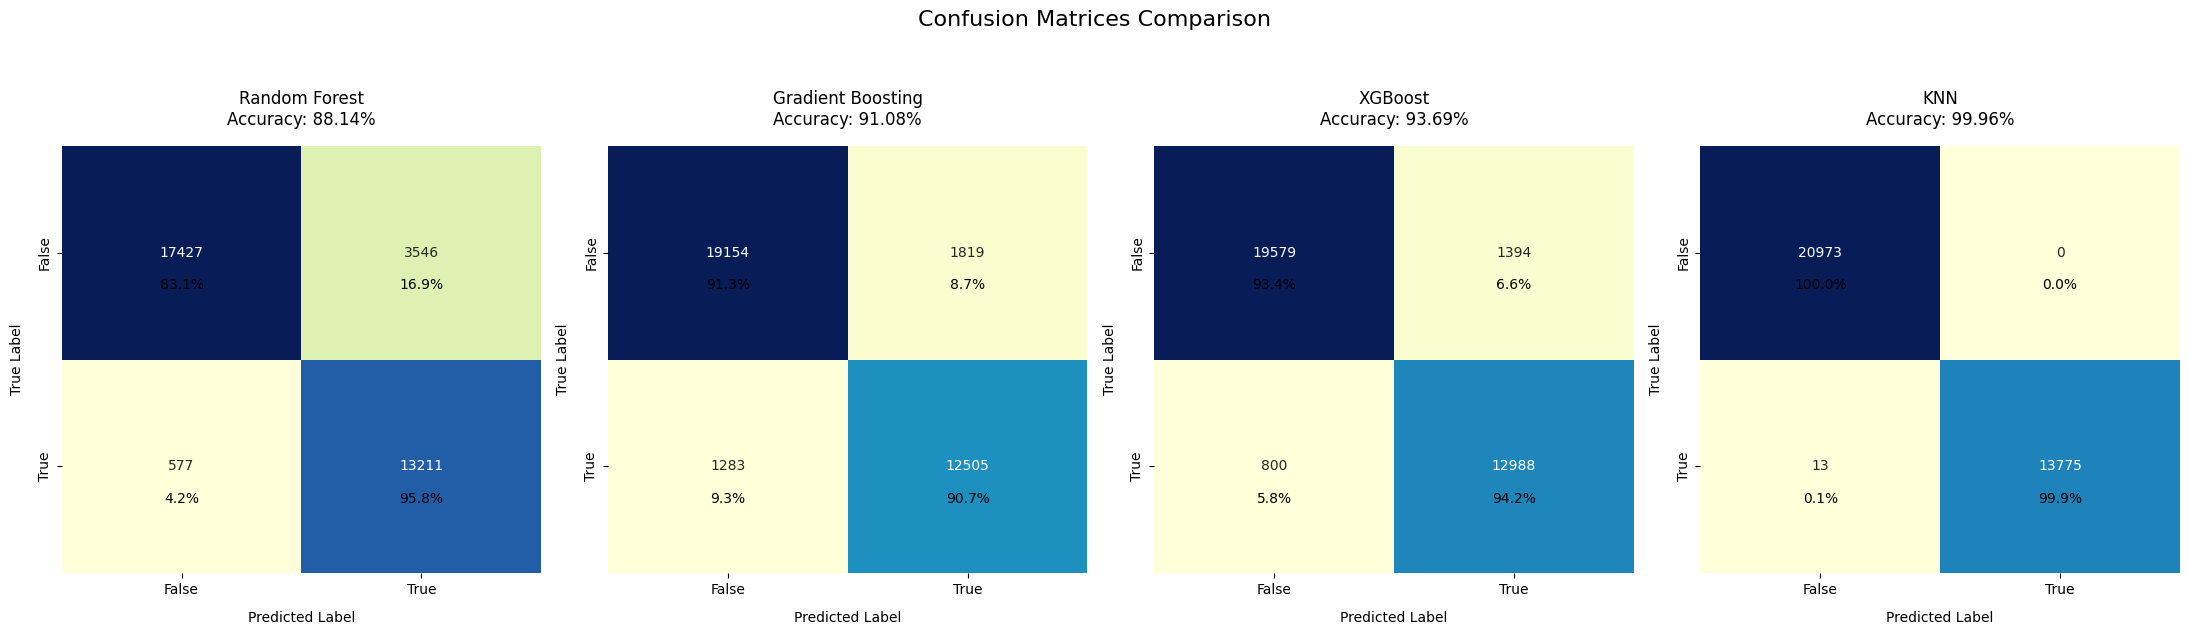


Model Performance Comparison
+-------------------+------------+-------------+----------+------------+--------------------+--------------------+
| Model             | Accuracy   | Precision   | Recall   | F1-Score   | Class 0 (False)    | Class 1 (True)     |
+===================+============+=============+==========+============+====================+====================+
| Random Forest     | 88.14%     | 78.84%      | 95.82%   | 86.50%     | TN=17427 | FP=3546 | FN=577 | TP=13211  |
+-------------------+------------+-------------+----------+------------+--------------------+--------------------+
| Gradient Boosting | 91.08%     | 87.30%      | 90.69%   | 88.97%     | TN=19154 | FP=1819 | FN=1283 | TP=12505 |
+-------------------+------------+-------------+----------+------------+--------------------+--------------------+
| XGBoost           | 93.69%     | 90.31%      | 94.20%   | 92.21%     | TN=19579 | FP=1394 | FN=800 | TP=12988  |
+-------------------+------------+-------------+--

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tabulate import tabulate
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Define models
models = [
    ("Random Forest", RandomForestClassifier(
        n_estimators=300, max_depth=20,
        class_weight='balanced_subsample',
        max_features='log2', random_state=42)),

    ("Gradient Boosting", GradientBoostingClassifier(
        n_estimators=150, learning_rate=0.1,
        max_depth=5, min_samples_split=10,
        subsample=0.8, random_state=42)),

    ("XGBoost", XGBClassifier(
        use_label_encoder=False, eval_metric='mlogloss',
        learning_rate=0.1, n_estimators=150,
        max_depth=6, subsample=0.8,
        colsample_bytree=0.8, random_state=42)),

    ("KNN", KNeighborsClassifier(n_neighbors=5))
]

# Create subplots for confusion matrices
fig, axes = plt.subplots(1, len(models), figsize=(22, 6))
fig.suptitle('Confusion Matrices Comparison', fontsize=16, y=1.05)

# Plot confusion matrices
for idx, (name, model) in enumerate(models):
    model.fit(X_train_fixed, y_train)
    y_pred = model.predict(X_test_fixed)
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
                xticklabels=['False', 'True'],
                yticklabels=['False', 'True'],
                ax=axes[idx], cbar=False)

    accuracy = accuracy_score(y_test, y_pred)
    axes[idx].set_title(f"{name}\nAccuracy: {accuracy:.2%}", pad=15)
    axes[idx].set_xlabel('Predicted Label', labelpad=10)
    axes[idx].set_ylabel('True Label', labelpad=10)

    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    for i in range(2):
        for j in range(2):
            axes[idx].text(j+0.5, i+0.65, f"{cm_norm[i,j]:.1%}",
                           ha='center', va='center', color='black', fontsize=10)

plt.tight_layout()
plt.show()

# Tabular metrics
table_data = []
for name, model in models:
    y_pred = model.predict(X_test_fixed)
    cm = confusion_matrix(y_test, y_pred)
    table_data.append([
        name,
        f"{accuracy_score(y_test, y_pred):.2%}",
        f"{precision_score(y_test, y_pred):.2%}",
        f"{recall_score(y_test, y_pred):.2%}",
        f"{f1_score(y_test, y_pred):.2%}",
        f"TN={cm[0,0]} | FP={cm[0,1]}",
        f"FN={cm[1,0]} | TP={cm[1,1]}"
    ])

print("\n\033[1mModel Performance Comparison\033[0m")
print(tabulate(table_data,
               headers=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score',
                        'Class 0 (False)', 'Class 1 (True)'],
               tablefmt='grid'))


LLM

In [ ]:
!pip install datasets transformers torch

In [ ]:
!pip install --upgrade transformers

In [ ]:
# 1. Split Data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df['clean_claim'], df['target'],
    test_size=0.3,
    stratify=df['target'],
    random_state=42
)

# 2. Tokenization & Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset

model_checkpoint = "nreimers/MiniLMv2-L6-H384-distilled-from-BERT-Large"
#microsoft/bitnet-b1.58-2B-4T
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

train_dataset = Dataset.from_dict({"text": X_train.tolist(), "label": y_train.tolist()})
test_dataset = Dataset.from_dict({"text": X_test.tolist(), "label": y_test.tolist()})

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

# 3. Model & Trainer
from transformers import TrainingArguments, Trainer
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=2,
    id2label={0: "False", 1: "True"},
    label2id={"False": 0, "True": 1}
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": (preds == labels).mean(),
        "precision": precision_score(labels, preds, zero_division=0),
        "recall": recall_score(labels, preds, zero_division=0),
        "f1": f1_score(labels, preds, zero_division=0),
    }

# Minimal TrainingArguments that works across versions
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    save_total_limit=1,
    # Evaluation will be done manually after each epoch
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics
)

# Manual training loop with evaluation after each epoch
for epoch in range(1):  # num_train_epochs
    print(f"\nEpoch {epoch + 1}")
    trainer.train()

    # Evaluate after each epoch
    eval_results = trainer.evaluate()
    print(f"Evaluation results after epoch {epoch + 1}:")
    print(eval_results)

    # Save model after each epoch
    trainer.save_model(f"./results/checkpoint-{epoch + 1}")

# Final evaluation
final_results = trainer.evaluate()
print("\nFinal evaluation results:")
print(final_results)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/81108 [00:00<?, ? examples/s]

Map:   0%|          | 0/34761 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/46.4M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nreimers/MiniLMv2-L6-H384-distilled-from-BERT-Large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/45.8M [00:00<?, ?B/s]


Epoch 1


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nishanth4011 (nishanth4011-florida-state-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,0.464600
1000,0.243900
1500,0.157200
2000,0.079100
2500,0.042400
3000,0.048600
3500,0.031500
4000,0.026700
4500,0.028700
5000,0.014100


Evaluation results after epoch 1:
{'eval_loss': 0.0006741126417182386, 'eval_accuracy': 0.9996260176634735, 'eval_precision': 1.0, 'eval_recall': 0.999057151145924, 'eval_f1': 0.9995283532271524, 'eval_runtime': 43.6036, 'eval_samples_per_second': 797.205, 'eval_steps_per_second': 49.835, 'epoch': 3.0}

Final evaluation results:
{'eval_loss': 0.0006741126417182386, 'eval_accuracy': 0.9996260176634735, 'eval_precision': 1.0, 'eval_recall': 0.999057151145924, 'eval_f1': 0.9995283532271524, 'eval_runtime': 45.324, 'eval_samples_per_second': 766.944, 'eval_steps_per_second': 47.944, 'epoch': 3.0}


In [ ]:
# 2. Data Preparation
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_claim'], df['target'],
    test_size=0.3,
    stratify=df['target'],
    random_state=42
)

# 3. Setup Tokenizer and Model
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from datasets import Dataset

# Initialize tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Create datasets
def create_dataset(texts, labels):
    encodings = tokenizer(texts.tolist(), padding='max_length', truncation=True, max_length=128)
    return Dataset.from_dict({
        'input_ids': encodings['input_ids'],
        'attention_mask': encodings['attention_mask'],
        'labels': labels.tolist()
    })

train_dataset = create_dataset(X_train, y_train)
test_dataset = create_dataset(X_test, y_test)

# 4. Model Initialization
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=2
)

# 5. Training Setup - Using only basic arguments
from transformers import Trainer, TrainingArguments

# Minimal TrainingArguments that work in all versions
training_args = TrainingArguments(
    output_dir='./results',
    per_device_train_batch_size=8,  # Reduced for compatibility
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    save_total_limit=1,
    logging_steps=50,
    seed=42
)

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {
        'accuracy': accuracy_score(p.label_ids, preds),
        'precision': precision_score(p.label_ids, preds, zero_division=0),
        'recall': recall_score(p.label_ids, preds, zero_division=0),
        'f1': f1_score(p.label_ids, preds, zero_division=0)
    }

# 6. Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# 7. Training with manual evaluation
print("Starting training...")
for epoch in range(1):  # num_train_epochs
    print(f"\nEpoch {epoch + 1}/3")
    trainer.train()

    # Manual evaluation
    eval_results = trainer.evaluate()
    print(f"Evaluation results after epoch {epoch + 1}:")
    for key, value in eval_results.items():
        if isinstance(value, float):
            print(f"{key}: {value:.4f}")
        else:
            print(f"{key}: {value}")

# 8. Final evaluation
print("\nRunning final evaluation...")
final_results = trainer.evaluate()
print("\nFinal evaluation results:")
for key, value in final_results.items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")

# 9. Save model
trainer.save_model("./final_model")
print("\nModel saved to ./final_model")

# Note about initialization
print("\nNote: The warning about initialized weights is normal - these classification layer weights are learned during training.")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/3


Step,Training Loss
50,0.631600
100,0.546100
150,0.496700
200,0.505300
250,0.482300
300,0.428300
350,0.436700
400,0.355700
450,0.318400
500,0.349800


Evaluation results after epoch 1:
eval_loss: 0.0010
eval_accuracy: 0.9996
eval_precision: 1.0000
eval_recall: 0.9991
eval_f1: 0.9995
eval_runtime: 125.3908
eval_samples_per_second: 277.2210
eval_steps_per_second: 34.6600
epoch: 3.0000

Running final evaluation...

Final evaluation results:
eval_loss: 0.0010
eval_accuracy: 0.9996
eval_precision: 1.0000
eval_recall: 0.9991
eval_f1: 0.9995
eval_runtime: 129.8726
eval_samples_per_second: 267.6550
eval_steps_per_second: 33.4640
epoch: 3.0000

Model saved to ./final_model

Note: The warning about initialized weights is normal - these classification layer weights are learned during training.


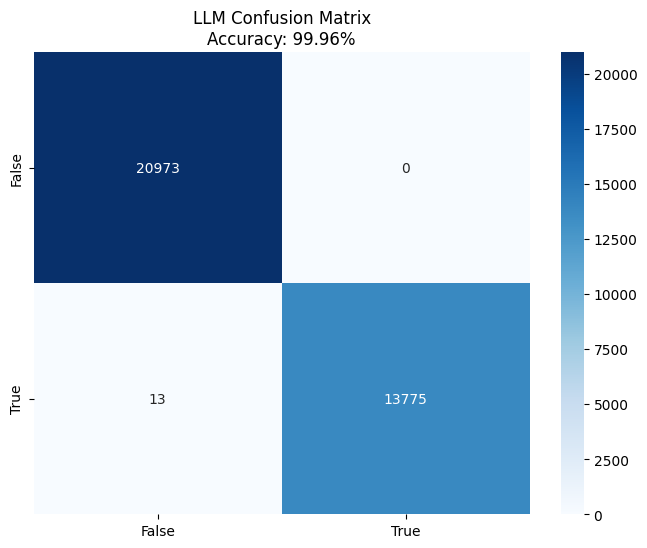

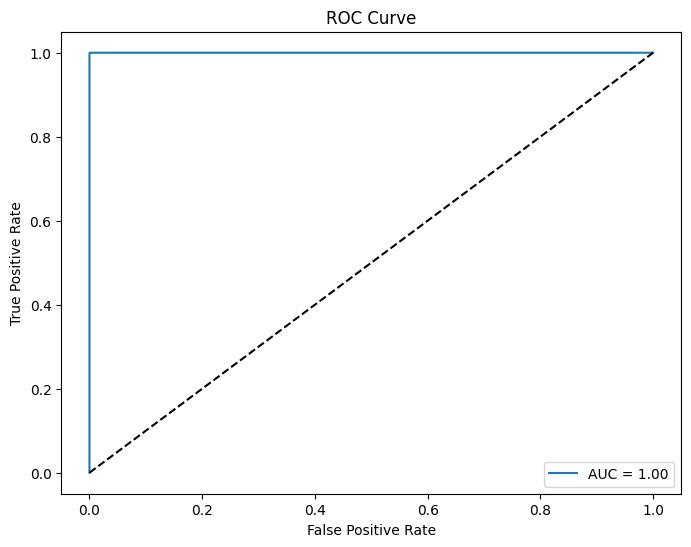

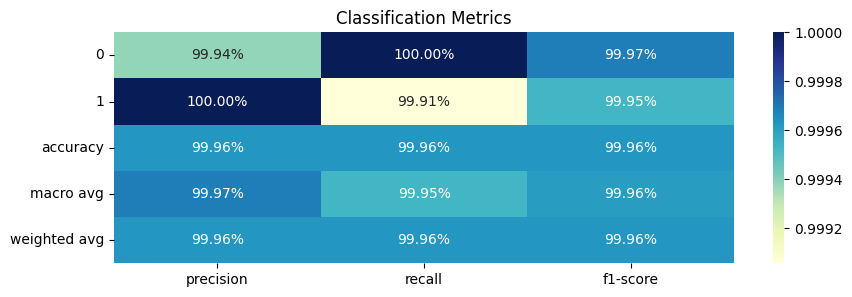


LLM Performance Summary
Accuracy: 99.96%
Precision (True): 100.00%
Recall (True): 99.91%
F1 (True): 99.95%
AUC: 1.000


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# 1. Move predictions to CPU and get class probabilities
predictions = trainer.predict(tokenized_test)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids
probs = torch.softmax(torch.tensor(predictions.predictions).cpu(), dim=1).numpy()[:, 1]  # Fixed device issue

# 2. Essential Plots ------------------------------------------------------------

# A. Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['False', 'True'],
            yticklabels=['False', 'True'])
plt.title(f'LLM Confusion Matrix\nAccuracy: {accuracy_score(y_true, y_pred):.2%}')
plt.savefig('llm_confusion.png', bbox_inches='tight', dpi=300)
plt.show()

# B. ROC Curve
fpr, tpr, _ = roc_curve(y_true, probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc(fpr, tpr):.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.savefig('llm_roc.png', bbox_inches='tight', dpi=300)
plt.show()

# C. Classification Report Heatmap
report = classification_report(y_true, y_pred, output_dict=True)
plt.figure(figsize=(10, 3))
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T[['precision', 'recall', 'f1-score']],
            annot=True, fmt='.2%', cmap='YlGnBu')
plt.title('Classification Metrics')
plt.savefig('llm_metrics.png', bbox_inches='tight', dpi=300)
plt.show()

# 3. Performance Summary --------------------------------------------------------
print("\n\033[1mLLM Performance Summary\033[0m")
print("="*50)
print(f"Accuracy: {accuracy_score(y_true, y_pred):.2%}")
print(f"Precision (True): {precision_score(y_true, y_pred, pos_label=1):.2%}")
print(f"Recall (True): {recall_score(y_true, y_pred, pos_label=1):.2%}")
print(f"F1 (True): {f1_score(y_true, y_pred, pos_label=1):.2%}")
print(f"AUC: {auc(fpr, tpr):.3f}")

Comparing Base-line models and LLM

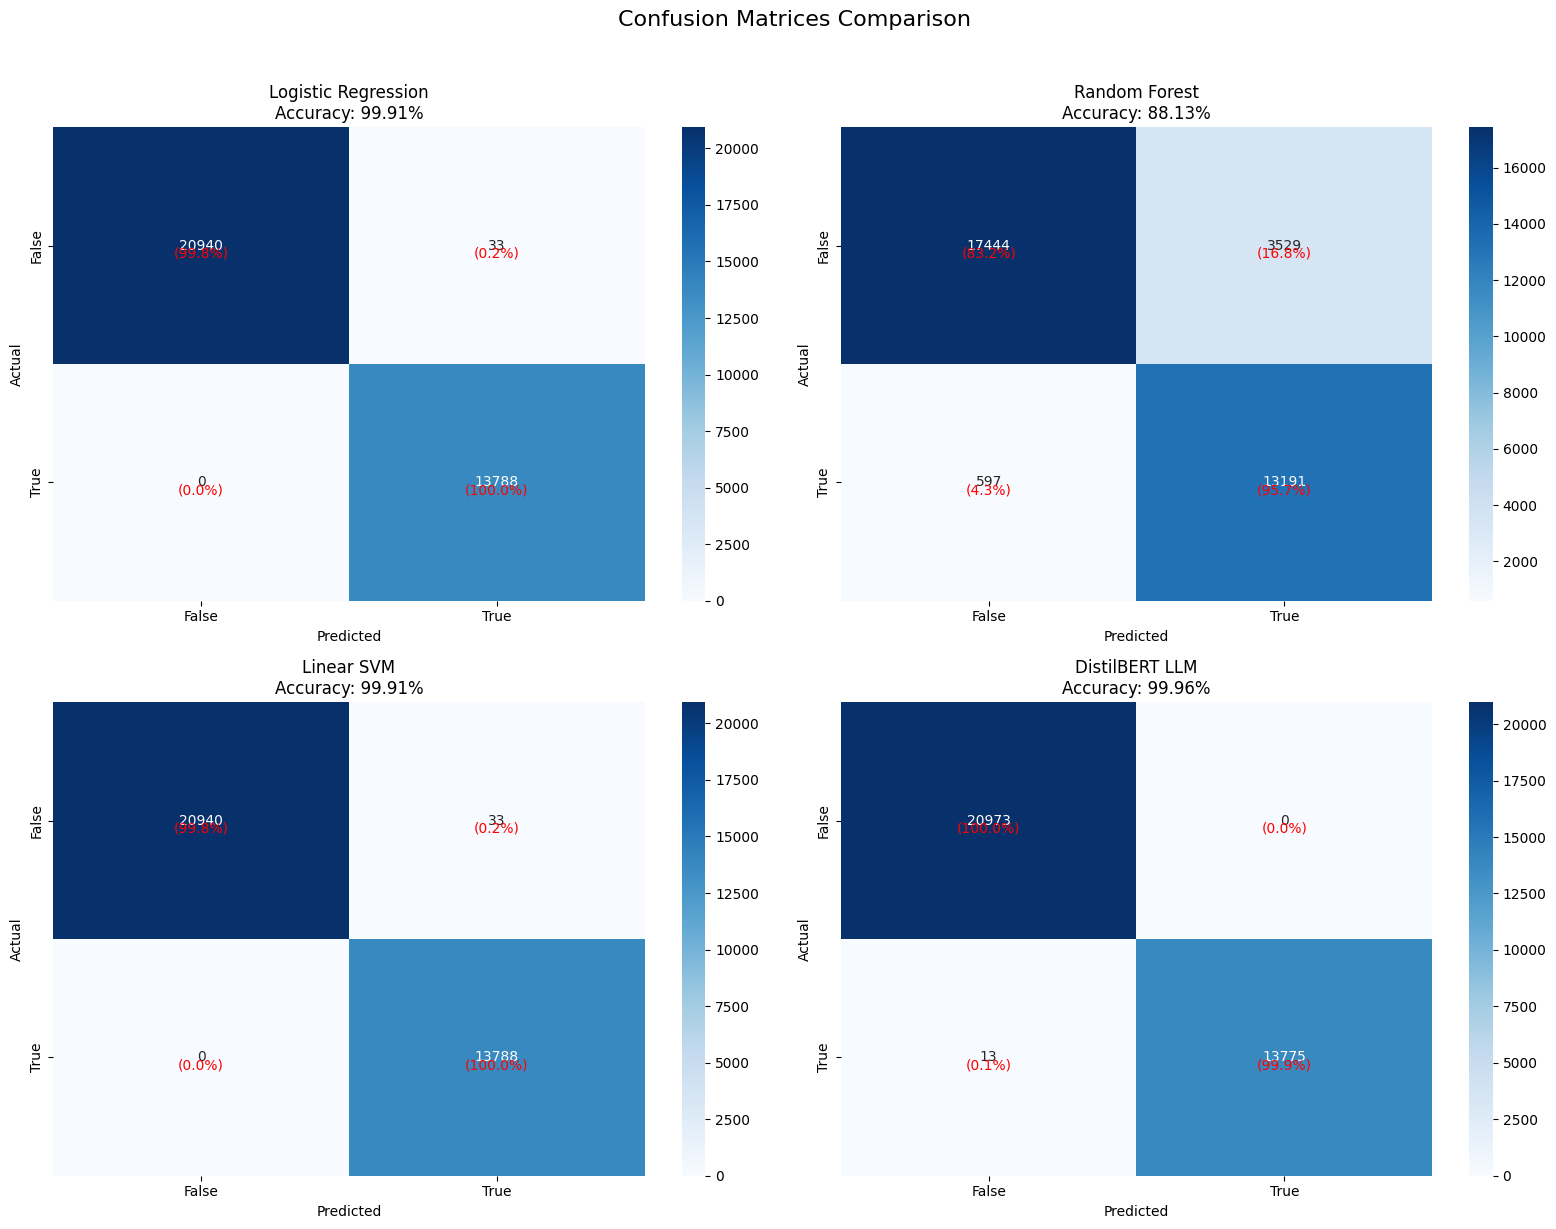

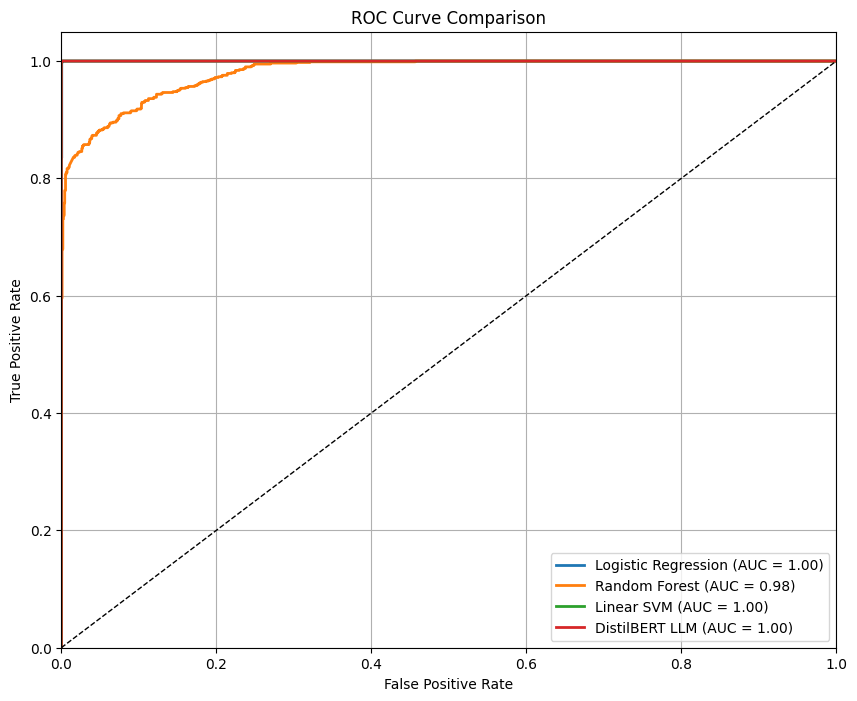

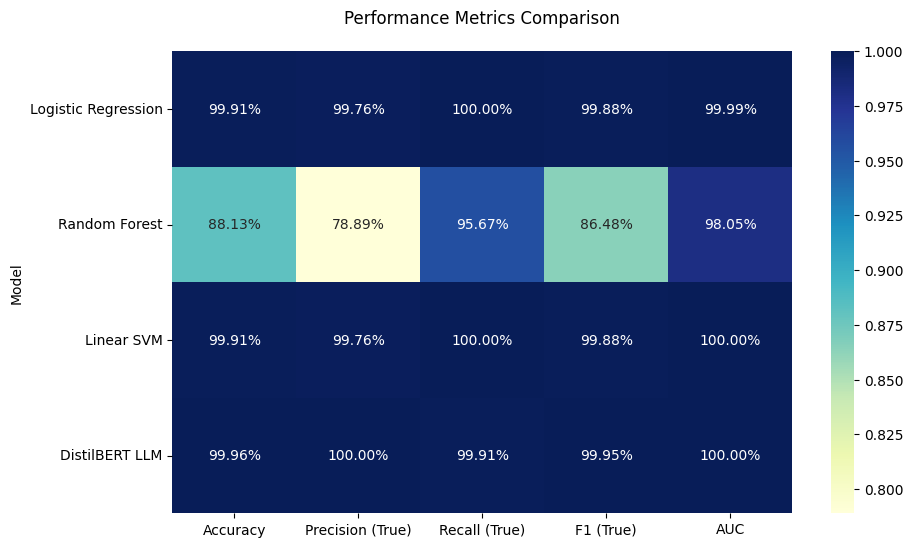


Model Performance Comparison
+---------------------+------------+-------+--------------------+-----------------+
| Model               | Accuracy   |   AUC | Precision (True)   | Recall (True)   |
+=====================+============+=======+====================+=================+
| Logistic Regression | 99.91%     |  1    | 99.76%             | 100.00%         |
+---------------------+------------+-------+--------------------+-----------------+
| Random Forest       | 88.13%     |  0.98 | 78.89%             | 95.67%          |
+---------------------+------------+-------+--------------------+-----------------+
| Linear SVM          | 99.91%     |  1    | 99.76%             | 100.00%         |
+---------------------+------------+-------+--------------------+-----------------+
| DistilBERT LLM      | 99.96%     |  1    | 100.00%            | 99.91%          |
+---------------------+------------+-------+--------------------+-----------------+

Saved visualizations:
- all_models_confusion.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from tabulate import tabulate

# 1. Get LLM predictions (assuming trainer is already trained)
llm_predictions = trainer.predict(tokenized_test)
y_pred_llm = np.argmax(llm_predictions.predictions, axis=1)
y_probs_llm = torch.softmax(torch.tensor(llm_predictions.predictions), dim=1).numpy()[:, 1]

# 2. Get baseline model predictions
models = {
    "Logistic Regression": lr,
    "Random Forest": rf,
    "Linear SVM": svm,
    "DistilBERT LLM": None  # Special handling for LLM
}

results = {}
for name, model in models.items():
    if model:  # For baseline models
        y_pred = model.predict(X_test_fixed)
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test_fixed)[:, 1]
        else:  # For LinearSVC
            y_prob = model.decision_function(X_test_fixed)
            y_prob = 1 / (1 + np.exp(-y_prob))  # Convert to probabilities
    else:  # For LLM
        y_pred = y_pred_llm
        y_prob = y_probs_llm

    results[name] = {
        "pred": y_pred,
        "prob": y_prob,
        "accuracy": accuracy_score(y_test, y_pred)
    }

# 3. Confusion Matrices Grid
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Confusion Matrices Comparison', fontsize=16, y=1.02)

for (name, data), ax in zip(results.items(), axes.flatten()):
    cm = confusion_matrix(y_test, data["pred"])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['False', 'True'],
                yticklabels=['False', 'True'])
    ax.set_title(f'{name}\nAccuracy: {data["accuracy"]:.2%}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

    # Add normalized percentages
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    for i in range(2):
        for j in range(2):
            ax.text(j+0.5, i+0.5, f"\n({cm_norm[i,j]:.1%})",
                   ha='center', va='center', color='red', fontsize=10)

plt.tight_layout()
plt.savefig('all_models_confusion.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. ROC Curve Comparison
plt.figure(figsize=(10, 8))
for name, data in results.items():
    fpr, tpr, _ = roc_curve(y_test, data["prob"])
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('all_models_roc.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. Metrics Heatmap
metrics = []
for name, data in results.items():
    report = classification_report(y_test, data["pred"], output_dict=True)
    metrics.append({
        'Model': name,
        'Accuracy': report['accuracy'],
        'Precision (True)': report['1']['precision'],
        'Recall (True)': report['1']['recall'],
        'F1 (True)': report['1']['f1-score'],
        'AUC': auc(*roc_curve(y_test, data["prob"])[:2])
    })

metrics_df = pd.DataFrame(metrics).set_index('Model')

plt.figure(figsize=(10, 6))
sns.heatmap(metrics_df, annot=True, fmt='.2%', cmap='YlGnBu')
plt.title('Performance Metrics Comparison', pad=20)
plt.savefig('all_models_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# 6. Print comparison table
print("\n\033[1mModel Performance Comparison\033[0m")
print("="*50)
print(tabulate(
    [(name,
      f"{data['accuracy']:.2%}",
      f"{auc(*roc_curve(y_test, data['prob'])[:2]):.2f}",
      f"{classification_report(y_test, data['pred'], output_dict=True)['1']['precision']:.2%}",
      f"{classification_report(y_test, data['pred'], output_dict=True)['1']['recall']:.2%}")
     for name, data in results.items()],
    headers=["Model", "Accuracy", "AUC", "Precision (True)", "Recall (True)"],
    tablefmt="grid"
))

# 7. Save all metrics
metrics_df.to_csv('all_models_comparison.csv')
print("\n\033[1mSaved visualizations:\033[0m")
print("- all_models_confusion.png")
print("- all_models_roc.png")
print("- all_models_heatmap.png")
print("- all_models_comparison.csv")

In [ ]:
def predict_claim(text, model, model_type='baseline'):
    """
    Unified prediction function that handles feature dimension mismatch
    """
    cleaned = preprocess_text(text)

    if model_type == 'baseline':
        # Transform using the original vectorizer
        vectorized = tfidf_enhanced.transform([cleaned])

        # Handle dimension mismatch by padding with zeros if needed
        if vectorized.shape[1] < model.n_features_in_:
            from scipy.sparse import hstack
            padding = np.zeros((1, model.n_features_in_ - vectorized.shape[1]))
            vectorized = hstack([vectorized, padding])

        pred = model.predict(vectorized)[0]
    else:  # LLM model
        model = model.cpu()
        inputs = tokenizer(cleaned, return_tensors="pt", padding=True, truncation=True, max_length=128)
        with torch.no_grad():
            outputs = model(**inputs)
        pred = torch.argmax(outputs.logits, dim=1).item()

    return "True" if pred == 1 else "False"

# Sample claims to test
sample_claims = [
    "Vitamin D prevents all diseases",
    "Exercise improves cardiovascular health",
    "5G towers spread viruses",
    "Vaccines cause autism",
    "Eating fruits and vegetables improves overall health"
]

# Prepare all models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42).fit(X_train_fixed, y_train),
    "Random Forest": RandomForestClassifier(n_estimators=300, max_depth=20, class_weight='balanced_subsample',
                                         max_features='log2', random_state=42).fit(X_train_fixed, y_train),
    "Linear SVM": LinearSVC(class_weight='balanced', dual=False, random_state=42, max_iter=10000).fit(X_train_fixed, y_train),
    "DistilBERT LLM": trainer.model
}

print("\n=== Sample Predictions Comparison ===")
print("="*60)
for claim in sample_claims:
    print(f"\nClaim: {claim}")
    for name, model in models.items():
        model_type = 'llm' if 'DistilBERT' in name else 'baseline'
        try:
            prediction = predict_claim(claim, model, model_type)
            print(f"{name}: {prediction}")
        except Exception as e:
            print(f"{name}: Error - {str(e)}")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



=== Sample Predictions Comparison ===

Claim: Vitamin D prevents all diseases
Logistic Regression: True
Random Forest: True
Linear SVM: True
DistilBERT LLM: True

Claim: Exercise improves cardiovascular health
Logistic Regression: True
Random Forest: True
Linear SVM: True
DistilBERT LLM: True

Claim: 5G towers spread viruses
Logistic Regression: True
Random Forest: True
Linear SVM: True
DistilBERT LLM: False

Claim: Vaccines cause autism
Logistic Regression: False
Random Forest: False
Linear SVM: False
DistilBERT LLM: False

Claim: Eating fruits and vegetables improves overall health
Logistic Regression: True
Random Forest: True
Linear SVM: True
DistilBERT LLM: False


In [ ]:
import numpy as np
import torch
from sklearn.svm import SVC  # Replace LinearSVC with SVC
from scipy.special import softmax

def predict_claim(text, model, model_type='baseline'):
    """
    Unified prediction function that handles feature dimension mismatch and
    includes confidence levels for all models.
    """
    cleaned = preprocess_text(text)

    if model_type == 'baseline':
        # Transform using the original vectorizer
        vectorized = tfidf_enhanced.transform([cleaned])

        # Handle dimension mismatch by padding with zeros if needed
        if vectorized.shape[1] < model.n_features_in_:
            from scipy.sparse import hstack
            padding = np.zeros((1, model.n_features_in_ - vectorized.shape[1]))
            vectorized = hstack([vectorized, padding])

        # Get prediction probabilities for confidence
        probas = model.predict_proba(vectorized)[0]
        pred = np.argmax(probas)
        confidence = probas[pred]
    else:  # LLM model
        model = model.cpu()
        inputs = tokenizer(cleaned, return_tensors="pt", padding=True, truncation=True, max_length=128)
        with torch.no_grad():
            outputs = model(**inputs)

        # Get prediction probabilities (softmax) for confidence
        logits = outputs.logits.detach().numpy()
        probas = softmax(logits, axis=-1)[0]
        pred = np.argmax(probas)
        confidence = probas[pred]

    return "True" if pred == 1 else "False", confidence

# Sample claims to test
sample_claims = [
    "Vitamin D prevents all diseases",
    "Exercise improves cardiovascular health",
    "5G towers spread viruses",
    "Vaccines cause autism",
    "Eating fruits and vegetables improves overall health"
]

# Prepare all models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42).fit(X_train_fixed, y_train),
    "Random Forest": RandomForestClassifier(n_estimators=300, max_depth=20, class_weight='balanced_subsample',
                                         max_features='log2', random_state=42).fit(X_train_fixed, y_train),
    "SVC": SVC(probability=True, class_weight='balanced', random_state=42).fit(X_train_fixed, y_train),  # Using SVC instead of LinearSVC
    "DistilBERT LLM": trainer.model
}

print("\n=== Sample Predictions Comparison with Confidence ===")
print("="*80)
for claim in sample_claims:
    print(f"\nClaim: {claim}")
    for name, model in models.items():
        model_type = 'llm' if 'DistilBERT' in name else 'baseline'
        try:
            prediction, confidence = predict_claim(claim, model, model_type)
            print(f"{name}: {prediction} (Confidence: {confidence:.4f})")
        except Exception as e:
            print(f"{name}: Error - {str(e)}")



=== Sample Predictions Comparison with Confidence ===

Claim: Vitamin D prevents all diseases
Logistic Regression: True (Confidence: 0.8627)
Random Forest: True (Confidence: 0.5062)
SVC: False (Confidence: 0.7917)
DistilBERT LLM: True (Confidence: 1.0000)

Claim: Exercise improves cardiovascular health
Logistic Regression: True (Confidence: 0.9798)
Random Forest: True (Confidence: 0.5413)
SVC: True (Confidence: 0.9069)
DistilBERT LLM: True (Confidence: 1.0000)

Claim: 5G towers spread viruses
Logistic Regression: False (Confidence: 0.8094)
Random Forest: False (Confidence: 0.5031)
SVC: False (Confidence: 0.9973)
DistilBERT LLM: False (Confidence: 1.0000)

Claim: Vaccines cause autism
Logistic Regression: False (Confidence: 0.9801)
Random Forest: False (Confidence: 0.5605)
SVC: False (Confidence: 1.0000)
DistilBERT LLM: False (Confidence: 1.0000)

Claim: Eating fruits and vegetables improves overall health
Logistic Regression: False (Confidence: 0.6377)
Random Forest: True (Confidence: